In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [87]:
# 5 secs of data (20 * 5)
SEQ_LEN = 100 
FEATURE_LEN = 6
COLUMNS = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'label']

In [3]:
har_df = pd.read_csv('data/har.csv')

In [4]:
label_encoder = LabelEncoder()
har_df['label'] = label_encoder.fit_transform(har_df.activity)

In [5]:
har_df.head()

,subject_id,activity,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,label
0,1600,walking,90426757696641,4.972757,-0.158317,6.696732,0.314944,-1.022277,-0.309962,16
1,1600,walking,90426807196641,3.253720,-0.191835,6.107758,0.387382,-0.618541,-0.048972,16
2,1600,walking,90426856696641,2.801216,-0.155922,5.997625,0.070999,-0.209480,-0.195978,16
3,1600,walking,90426906196641,3.770868,-1.051354,7.731027,0.037975,0.254976,-0.156563,16
4,1600,walking,90426955696641,4.661511,0.169689,9.684695,0.073129,0.719431,-0.001035,16


In [94]:
train_df, test_df = train_test_split(har_df, train_size = .9, random_state=42, shuffle=False)
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
train_df.shape, test_df.shape

((2856541, 11), (317394, 11))

In [90]:
import itertools
from scipy import stats

def prepare_dataset(df):
    global SEQ_LEN, COLUMNS
    
    X = []
    y = []
    
    for i in range(0, len(df), SEQ_LEN):
        features = df.loc[i:i+SEQ_LEN-1, COLUMNS[:-1]].values
        label = stats.mode(df.loc[i:i+SEQ_LEN-1, COLUMNS[-1]].values)[0][0]
        
        if len(features) != SEQ_LEN:
            continue
        
        X.append(features.reshape(-1, SEQ_LEN, len(COLUMNS[:-1])))
        y.append(label)
        
    return np.concatenate(X), np.asarray(y)

In [84]:
X_train, y_train = prepare_dataset(train_df)

display(X_train.shape)
display(y_train.shape)

(28565, 100, 6)

(28565,)

In [85]:
X_train[0, :180, 0]

array([ 4.972757 ,  3.25372  ,  2.801216 ,  3.7708676,  4.661511 ,
        6.145916 ,  7.2592196,  7.3549876,  7.3190746,  7.548918 ,
        5.3318872,  4.4316673,  3.4093432,  3.1292217,  4.936844 ,
       11.669339 , 14.561535 , 17.616535 , 19.017143 , 15.775395 ,
       12.210428 ,  7.6494746,  6.8785415,  6.291962 ,  8.767567 ,
       12.732365 , 14.449007 , 17.678785 , 15.315708 , 19.761143 ,
       19.201498 , 11.374852 ,  8.841787 ,  5.8346696,  7.180211 ,
        9.0476885,  7.654263 , 10.292673 , 12.643779 , 13.172897 ,
       13.599066 , 12.605472 , 11.513716 , 11.908759 , 13.706804 ,
       13.034034 , 14.923059 , 17.28853  , 16.139313 , 19.752165 ,
       18.150444 , 10.34774  ,  8.616732 ,  8.293514 ,  8.377312 ,
        7.905654 ,  6.991069 , 10.000581 , 12.2798605, 15.634137 ,
       15.86398  , 11.633426 , 13.412318 , 11.973403 , 14.061147 ,
       12.674904 , 17.597382 , 15.7323   , 19.65879  , 19.146431 ,
       13.692439 , 10.742783 , 10.498574 ,  9.239224 ,  9.0883

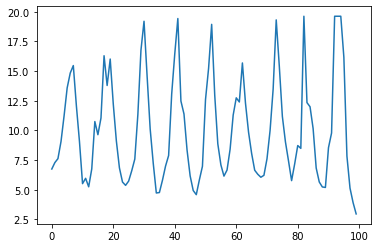

In [86]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(X_train[100, :1080, 0])), X_train[100, :1080, 0])

In [52]:
test_df.head()

,subject_id,activity,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,label
2856541,1646,stairs,1469101057176660,5.927744,-0.544382,1.801786,-0.453196,-0.850242,-1.097563,12
2856542,1646,stairs,1469101107162550,7.632416,-0.192434,1.409137,-0.899542,-1.831350,-1.386250,12
2856543,1646,stairs,1469101157148440,9.914090,-1.308132,0.583138,-0.700337,-2.292610,-1.574801,12
2856544,1646,stairs,1469101207134330,12.813468,-6.041469,3.432238,1.138309,-1.775957,-1.359618,12
2856545,1646,stairs,1469101257120220,13.950714,-9.661502,9.922918,0.976389,-0.369808,0.748540,12


In [91]:
X_test, y_test = prepare_dataset(test_df)

In [92]:
X_test.shape, y_test.shape

((3173, 100, 6), (3173,))

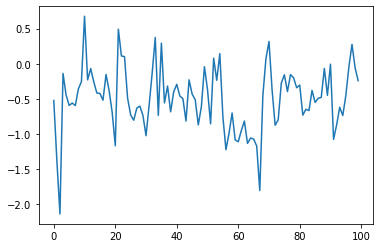

In [95]:
plt.plot(range(0, len(X_test[100, :1080, 0])), X_test[100, :1080, 0])

In [96]:
from numpy import save

save('data/X_train.npy', X_train)
save('data/y_train.npy', y_train)
save('data/X_test', X_test)
save('data/y_test', y_test)